In [52]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam, RMSprop

In [53]:
from curvefit import DatasetSpectra
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np

In [54]:
from plsr.analysis import plsr_r2_plot

In [55]:
def create_model(input_length):
    model = models.Sequential()
    
    model.add(layers.Conv1D(filters=10, kernel_size=5, strides=1, padding='same', input_shape=(input_length, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size=2, strides=2))
    
    # Second Conv1D + BatchNorm + MaxPooling
    model.add(layers.Conv1D(filters=10, kernel_size=5, strides=1, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size=2, strides=2))
    
    # Flatten the output
    model.add(layers.Flatten())
    
    # Fully connected layers + Dropout
    model.add(layers.Dense(360, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(180, activation='relu'))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Dense(1))
    
    return model

In [56]:
file_path = '~/data/dataset_681.csv'
domain_path = '~/data/dataset_565_domain.csv'

(<Figure size 1000x400 with 4 Axes>, <brokenaxes.BrokenAxes at 0x7f615421bd90>)

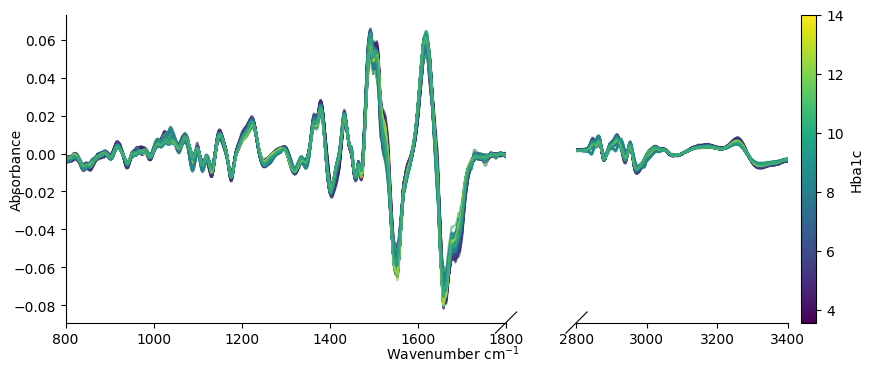

In [57]:
dataset = DatasetSpectra(file_path, domain_path)
dataset.select_max_hba1c(14)
dataset.savgol_filter(window_length=32, polyorder=2, deriv=1)
dataset.normalization('vector')
dataset.select_region([[800, 1800], [2800, 3400]])
dataset.drop_samples([287, 636])
dataset.plot_spectra()

In [58]:
dataset.n_samples

673

In [59]:
X = dataset.spectra
y = dataset.hba1c

In [60]:
discretizer = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='uniform', subsample=None, random_state=4)
categories = discretizer.fit_transform(y.reshape(-1, 1))

In [61]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=categories, random_state=34)

In [62]:
discretizer = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='uniform', subsample=None, random_state=4)
categories = discretizer.fit_transform(y_temp.reshape(-1, 1))
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=categories, random_state=14)

In [63]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(430, 3319) (430,)
(108, 3319) (108,)
(135, 3319) (135,)


In [64]:
input_length = X_train.shape[1]
model = create_model(input_length)
model.summary()

/home/mykola/miniconda3/envs/curvefit/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 3319, 10)       │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 3319, 10)       │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 1659, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 1659, 10)       │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 1659, 10)       │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 829, 10)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8290)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 360)            │     2,984,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 360)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 180)            │        64,980 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 180)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           181 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,050,571 (11.64 MB)

 Trainable params: 3,050,531 (11.64 MB)

 Non-trainable params: 40 (160.00 B)

In [65]:
np.random.seed(0)
tf.random.set_seed(0)

model.compile(optimizer=Adam(learning_rate=1e-5), # 0.00001
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.0
)

history = model.fit(X_train, y_train, 
                    epochs=1000,
                    batch_size=32,
                    validation_data=[X_val, y_val],
                    callbacks=[early_stopping, reduce_lr],
                    verbose=1)

Epoch 1/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 62.8826 - mean_absolute_error: 7.4879 - val_loss: 59.1109 - val_mean_absolute_error: 7.3228 - learning_rate: 1.0000e-05
Epoch 2/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 17.5402 - mean_absolute_error: 3.4422 - val_loss: 58.8539 - val_mean_absolute_error: 7.3052 - learning_rate: 1.0000e-05
Epoch 3/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 7.6763 - mean_absolute_error: 2.1785 - val_loss: 58.6365 - val_mean_absolute_error: 7.2903 - learning_rate: 1.0000e-05
Epoch 4/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 6.6478 - mean_absolute_error: 2.0824 - val_loss: 58.4893 - val_mean_absolute_error: 7.2802 - learning_rate: 1.0000e-05
Epoch 5/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 6.2829 - mean_absolute_error: 2.1120 - val_loss: 58.3863 - val_mean_absolute_error: 7.2731 - learning_rate: 1.0000e-05
Epoch 6/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 6.8526 - mean_absolute_error: 2.1852 

Text(0, 0.5, 'Loss')

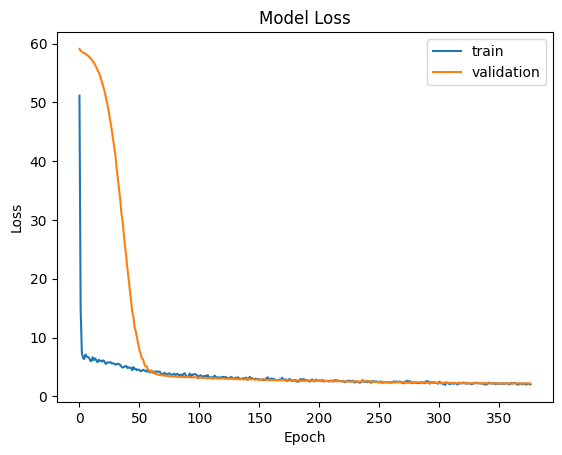

In [66]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [67]:
loss, mae = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'Test Loss: {loss:.3f}, Test MAE: {mae:.3f}, R2: {r2:.3f}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6217 - mean_absolute_error: 0.9794 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Test Loss: 1.655, Test MAE: 0.986, R2: 0.701


(<Figure size 600x400 with 1 Axes>,
 <Axes: xlabel='HbA1c% measured', ylabel='HbA1c% predicted'>)

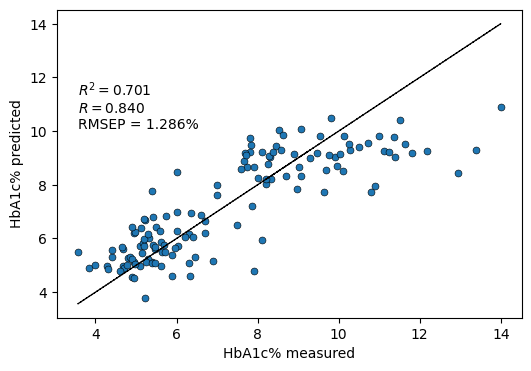

In [68]:
plsr_r2_plot(y_test, y_pred.reshape(-1))